In [1]:
import os, sys
import argparse
import time

import xml.etree.ElementTree as ET

from sumolib import checkBinary

import traci
import traci.constants as tc

import matplotlib.pyplot as plt

In [2]:
from routeGenerate import GenerateRoutes 

In [3]:
import curbside
import utils

In [4]:
net_xml = "seattle.net.xml"
add_xml = "seattle.add.xml"
rou_xml = "seattle.trips.xml"

In [5]:
def simulate(seconds = 3600, gui = False):
    """
    Main function that controls the simulation
    """

    road_network = utils.create_graph('seattle.net.xml')
    
    # create agent curbs
    curb_ids = []
    root = ET.parse(add_xml).getroot()
    for child in root.iter('additional'):
        for kid in child.iter('parkingArea'):
            curb_ids.append(kid.get('id'))
    
    curbs = {}
    for curb_id in curb_ids:
        curbs[curb_id] = curbside.SmartCurbside(1, 'seattle.add.xml', 'seattle.net.xml', curb_id, ['passenger', 'taxi'], road_network)
        
    for curb in curbs:
        curb.find_neighborhood(road_network)
    
    reroute_num = 0

    if gui:
        sumoBinary = checkBinary('sumo-gui')
    else:
        sumoBinary = checkBinary('sumo')

    traci.start([sumoBinary, "-c", "seattle.sumocfg"])
    
    start = time.time()
    # simulation
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
        if traci.simulation.getTime() == seconds:
            running_time = time.time() - start
            break
        
        for curb in curbs:
            # update neighbors info
            curb._update_nearby_curb()
            
            # check if there is any vehicle enters
            v_enter = set(traci.edge.getLastStepVehicleIDs(curb.edge)) - curb.moving_vehicle
            
            # no need to subtract v_leave, because v_leave ideally should be maintained per curb, but now inner loop is on curbs
            # v_enter -= v_leave
            
            for veh in v_enter:
                # new vehicle is for sure not confirmed, no need to check confirmed=True
                # if vehicle has next stops and currect edge is one of them - this vehicle should be considered for current edge
                # also check vehicle is not stopped - during parking right before departure getNextStops() will return original travel plan, which shouldn't happen
                if traci.vehicle.getNextStops(veh) and curb.id in [item[2] for item in traci.vehicle.getNextStops(veh)] and not traci.vehicle.isStopped(veh):
                    # if the trips is not ending and the current edge is the parking stop
                    # v_leave should be excluded
                    if any(traci.vehicle.getVehicleClass(veh) in s for s in curb.vclass) and len(curb.occupied_vehicle) < curb.capacity:
                        # if can park, add to occupied set : planned + parked
                        curb.occupied_vehicle.add(veh)
                    else:
                        # cannot park at this edge, reroute
                        # item._reroute_choice() returns (curb_id, distance) tuple
                        traci.vehicle.rerouteParkingArea(veh, curb._reroute_choice()[0])
                        reroute_num += 1
                        
            # v_leave : parked vehicle of last time step - parked vehicle at this time step
            v_leave = curb.parked_vehicle - set(traci.parkingarea.getVehicleIDs(curb.id))
            # remove v_leave from occupied set : planned + parked
            curb.occupied_vehicle -= v_leave
            # update parked vehicle set
            curb.parked_vehicle = set(traci.parkingarea.getVehicleIDs(curb.id))
            # update moving vehicles on the hosting edge
            curb.moving_vehicle = set(traci.edge.getLastStepVehicleIDs(curb.edge))

    # enter False to disconnect before SUMO finishes
    traci.close()

    # flush out intermmediate results
    sys.stdout.flush()
    
    return reroute_num, running_time

In [6]:
demand_factors = [1.0, 1.5, 2.0, 2.5]
# demand_factors = [3]

In [13]:
GenerateRoutes(demand_factor=1.0, taxi_factor=1.0, flow_num=200, simulate_hour=12, seed=1)
reroute_num, running_time = simulate(seconds = 3600, gui = True)

seattle.trips.xml re-generated. (demand factor = 1.0 )


In [17]:
traci.close()

In [18]:
demand_factors = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
# demand_factors = [1.0, 1.5, 2.0, 2.5]

reroute_nums = []
for demand_factor in demand_factors:
    GenerateRoutes(demand_factor=demand_factor, taxi_factor=1, taxi_num=100, flow_num=200, simulate_hour=12, seed=1)
    reroute_num, running_time = simulate(seconds = 3600, gui = False)
    print('demand factor: {}, # of reroute: {}, running time: {}'.format(demand_factor, reroute_num, round(running_time,1)))
    reroute_nums.append(reroute_num)
traci.close()

plt.figure(figsize=(6,4))
plt.plot(demand_factors, reroute_nums)
plt.xlabel('Scale factor of parking demand')
plt.ylabel('Num of reroute')
plt.ylim(0, 50)

seattle.trips.xml re-generated. (demand factor = 1.0 )
demand factor: 1.0, # of reroute: 34, running time: 142.7
seattle.trips.xml re-generated. (demand factor = 1.2 )
demand factor: 1.2, # of reroute: 38, running time: 148.1
seattle.trips.xml re-generated. (demand factor = 1.4 )
demand factor: 1.4, # of reroute: 44, running time: 143.6
seattle.trips.xml re-generated. (demand factor = 1.6 )
demand factor: 1.6, # of reroute: 65, running time: 147.1
seattle.trips.xml re-generated. (demand factor = 1.8 )
demand factor: 1.8, # of reroute: 68, running time: 136.7
seattle.trips.xml re-generated. (demand factor = 2.0 )


IndexError: list index out of range

Text(0.5, 1.0, 'taxi_factor = 1 (num of taxi = 100)')

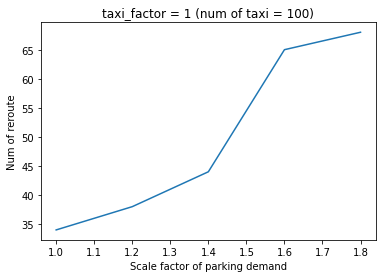

In [22]:
plt.figure(figsize=(6,4))
plt.plot(demand_factors[0:5], reroute_nums)
plt.xlabel('Scale factor of parking demand')
plt.ylabel('Num of reroute')
plt.title('taxi_factor = 1 (num of taxi = 100)')
# plt.ylim(0, 50)

In [10]:
demand_factors = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
# demand_factors = [3]

In [19]:
reroute_nums = []
for demand_factor in demand_factors:
    GenerateRoutes(demand_factor, simulate_hour = 12, seed = 1)
    reroute_num, running_time = simulate(seconds = 3600, gui = False)
    print('demand factor: {}, # of reroute: {}, running time: {}'.format(demand_factor, reroute_num, round(running_time,1)))
    reroute_nums.append(reroute_num)

seattle.trips.xml re-generated. (demand factor = 1.0 )
demand factor: 1.0, # of reroute: 14, running time: 132.8
seattle.trips.xml re-generated. (demand factor = 1.2 )
demand factor: 1.2, # of reroute: 22, running time: 132.4
seattle.trips.xml re-generated. (demand factor = 1.4 )
demand factor: 1.4, # of reroute: 22, running time: 127.8
seattle.trips.xml re-generated. (demand factor = 1.6 )
demand factor: 1.6, # of reroute: 26, running time: 130.8
seattle.trips.xml re-generated. (demand factor = 1.8 )
demand factor: 1.8, # of reroute: 36, running time: 134.2
seattle.trips.xml re-generated. (demand factor = 2.0 )
demand factor: 2.0, # of reroute: 47, running time: 135.3


In [17]:
traci.close()

(0.0, 50.0)

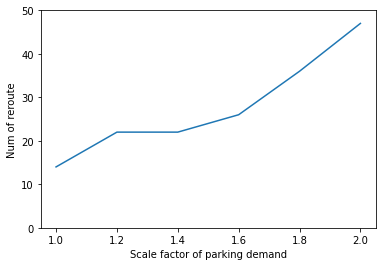

In [29]:
plt.figure(figsize=(6,4))
plt.plot(demand_factors, reroute_nums)
plt.xlabel('Scale factor of parking demand')
plt.ylabel('Num of reroute')
plt.ylim(0, 50)
# plt.grid(True)
